### Probablity Ratio Encoding With Pandas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
ds = pd.read_csv('train.csv',usecols=[ 'Sex','Cabin', 'Embarked', 'Survived'])

In [3]:
ds.head()

,Survived,Sex,Cabin,Embarked
0,0,male,NaN,S
1,1,female,C85,C
2,1,female,NaN,S
3,1,female,C123,S
4,0,male,NaN,S


In [4]:
# lets replace NaN values for Cabin and Embarked with label 'Missing'
ds['Cabin'] = ds['Cabin'].fillna('Missing')
ds['Embarked'] = ds['Embarked'].fillna('Missing')

In [5]:
ds.head()

,Survived,Sex,Cabin,Embarked
0,0,male,Missing,S
1,1,female,C85,C
2,1,female,Missing,S
3,1,female,C123,S
4,0,male,Missing,S


In [6]:
# Now we extract the first letter of the cabin
# to create a simpler variable for practice

ds['Cabin'] = ds['Cabin'].astype(str).str[0]

In [9]:
# let's remove the observations where Cabin = T as there are very few

ds = ds[ds['Cabin']!= 'T']
ds.shape

(890, 4)

In [10]:
# Lets have a look at number of unique categories for each feature
for column in ds.columns:
  print(f"column {column} has {len(ds[column].unique())} unique categories")

column Survived has 2 unique categories
column Sex has 2 unique categories
column Cabin has 8 unique categories
column Embarked has 4 unique categories


In [11]:
# let's have a look at unique labels
ds['Sex'].unique()

array(['male', 'female'], dtype=object)

In [12]:
ds['Embarked'].unique()

array(['S', 'C', 'Q', 'Missing'], dtype=object)

In [13]:
ds['Cabin'].unique()
# note that M is for Missing

array(['M', 'C', 'E', 'G', 'D', 'A', 'B', 'F'], dtype=object)

### Note: 
We calculate the ratio P(1)/P(0) using the train set, and then use those mappings in the test set.

Note that to implement this in pandas, we need to keep the target in the training set.

In [14]:
# Splitting the train and test set
X_train, X_test, y_train, y_test = train_test_split(
    ds[['Cabin', 'Sex', 'Embarked', 'Survived']],  
    ds['Survived'],  
    test_size=0.3,  
    random_state=10) 

# print the shape
X_train.shape, X_test.shape

((623, 4), (267, 4))

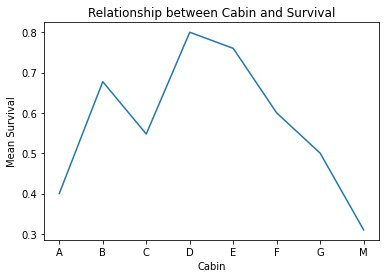

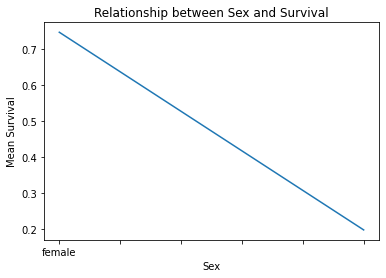

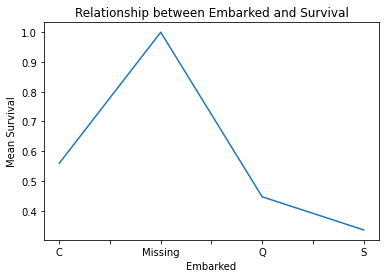

In [15]:
# let's plot the relationship of the categories with the target

for column in ['Cabin', 'Sex', 'Embarked']:
    fig = plt.figure()
    fig = X_train.groupby([column])['Survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(column))
    fig.set_ylabel('Mean Survival')
    plt.show()

We can see that the relationship between the target and cabin and embarked goes up and down, depending on the category.

In [18]:
# Let's calculate the probability of Survived =1 for each categories
prob_df = X_train.groupby(['Cabin'])['Survived'].mean()

# let's turn it into a dataframe
prob_df = pd.DataFrame(prob_df)

# print the data frame
print(prob_df)

       Survived
Cabin          
A      0.400000
B      0.677419
C      0.547619
D      0.800000
E      0.760000
F      0.600000
G      0.500000
M      0.309771


In [19]:
# Now we can calculate the probability of death i.e. survived = 0
prob_df['Died'] = 1-prob_df['Survived']

In [20]:
prob_df.head()

,Survived,Died
Cabin,,
A,0.400000,0.600000
B,0.677419,0.322581
C,0.547619,0.452381
D,0.800000,0.200000
E,0.760000,0.240000


In [21]:
# now we calculate the ratio
prob_df['Ratio'] = prob_df['Survived'] / prob_df['Died']

In [22]:
# lets see the result
prob_df.head()

,Survived,Died,Ratio
Cabin,,,
A,0.400000,0.600000,0.666667
B,0.677419,0.322581,2.100000
C,0.547619,0.452381,1.210526
D,0.800000,0.200000,4.000000
E,0.760000,0.240000,3.166667


In [23]:
# Now lets create a dictionary of ratio so that we can map them
ordered_labels = prob_df['Ratio'].to_dict()

# print the labels
ordered_labels

{'A': 0.6666666666666667,
 'B': 2.0999999999999996,
 'C': 1.210526315789474,
 'D': 4.000000000000001,
 'E': 3.166666666666667,
 'F': 1.4999999999999998,
 'G': 1.0,
 'M': 0.44879518072289154}

In [24]:
# replace the labels with ratio

X_train['Cabin'] = X_train['Cabin'].map(ordered_labels)
X_test['Cabin'] = X_test['Cabin'].map(ordered_labels)

In [25]:
# lets observe the results
X_train.head()

,Cabin,Sex,Embarked,Survived
359,0.448795,female,Q,1
7,0.448795,male,S,0
766,0.448795,male,C,0
340,1.500000,male,S,1
375,0.448795,female,C,1


In [26]:
# lets combine the above two methods to functions

def func_ratio_mappings(ds, col_name, target):
    tmp = pd.DataFrame(ds.groupby([col_name])[target].mean())
    tmp['non-target'] = 1 - tmp[target] 
    tmp['ratio'] = tmp[target] / tmp['non-target']
    return tmp['ratio'].to_dict()


def func_encode(train, test, col_name, ordinal_mapping):
    train[col_name] = train[col_name].map(ordinal_mapping)
    test[col_name] = test[col_name].map(ordinal_mapping)


In [28]:
# now lets look over the remaining categorical features and encode them too
for column in ['Sex', 'Embarked']:
    mappings = func_ratio_mappings(X_train, column, 'Survived')
    func_encode(X_train, X_test, column, mappings)

In [29]:
# let's view the result
X_train.head()

,Cabin,Sex,Embarked,Survived
359,0.448795,2.944444,0.807692,1
7,0.448795,0.246201,0.504854,0
766,0.448795,0.246201,1.270833,0
340,1.500000,0.246201,0.504854,1
375,0.448795,2.944444,1.270833,1


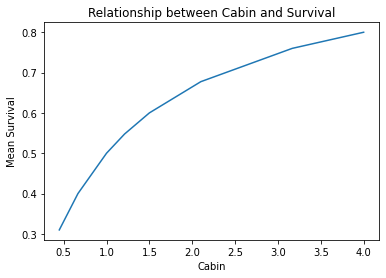

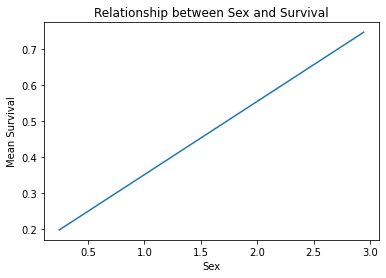

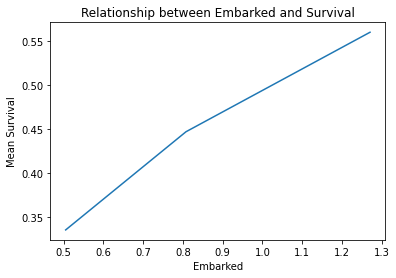

In [30]:
# let's plot the relationship of the categories with the target after encoding

for column in ['Cabin', 'Sex', 'Embarked']:
    fig = plt.figure()
    fig = X_train.groupby([column])['Survived'].mean().plot()
    fig.set_title('Relationship between {} and Survival'.format(column))
    fig.set_ylabel('Mean Survival')
    plt.show()

We can see that the curve has changed, and is more a like linear

### Advantages
- quick
- returns pandas dataframe
### Limitations of pandas:
- it does not preserve information from train data to propagate to test data

### Note
Replacing categorical labels with this code and method will generate missing values for categories present in the test set that were not seen in the training set. Therefore it is extremely important to handle rare labels before-hand. 

In addition, it will create NA or Inf(infinity) if the probability of target = 0 is zero, as the division by zero is not defined.